<a href="https://colab.research.google.com/github/asia281/VisualRecognition2024/blob/main/Assignment_1_Semantic_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visual Recognition HW1 - Semantic segmentation

## Overview
The goal of this task is to finish the implementation of a semantic segmentation model based on the [BiFPN](https://arxiv.org/abs/1911.09070) approach.
And test the capabilities of the model on [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/).

To be more precise the model will input a batch of RGB images of shape `(BATCH, 3, IMAGE_HEIGHT, IMAGE_WIDTH)` and output a segmentation mask `m` of shape `(BATCH, 3, PREDICTION_HEIGHT, PREDICTION_WIDTH)`.  
The mask will be such that
* `m[:, 0]` equals 1, whether the element of the image corresponds to the pet
* `m[:, 1]` equals 1, whether the element of the image corresponds to the background
* `m[:, 2]` equals 1, whether the element of the image corresponds to the pet outline

This notebook is divided into several sections:
* Preparation - 0 points (everything is already implemented)
  * Installation and imports of packages
  * code for preparation of the dataset
  * utils for visualization
* Model implementation - 7 points (split among several subtasks)
  * backbone preparation - 2 points (extracting features from the backbone and initial processing of them)
  * BiFPN feature fusion - 3 points (implementation of BiFPN feature aggregation mechanism)
  * segmentation head - 1 points
  * network - 1 points (assembling the whole model)
* Training and evaluation - 2 points
  * metrics - 1 point (you only need to implement accuracy and IOU metrics)
  * eval loop - 0 points (already implemented)
  * train loop - 1 point
* Inspection and Ablations - 3 points
  * checking the importance of BiFPN


## General information
Please write the code within
```python
## TODO {

## }
```
blocks.
Please do not modify other parts of the code.

## Preparation - 0 points

### Libraries

In [1]:
# A package for visualizing the architecture of the model
!pip install torchinfo

In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torchinfo
from typing import List, Optional, Tuple

### Dataset

In [3]:
# We downscale images to
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128

# We will make predictions in a smaller scale
PREDICTION_HEIGHT = 64
PREDICTION_WIDTH = 64


# We want to match data distribution
# of the backbone that we will introduce later
image_net_mean = [0.485, 0.456, 0.406]
image_net_std = [0.229, 0.224, 0.225]

input_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
        torchvision.transforms.ToTensor(),  # our input is an image
        torchvision.transforms.Normalize(image_net_mean, image_net_std),
    ]
)

target_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(
            (PREDICTION_HEIGHT, PREDICTION_WIDTH),
            interpolation=torchvision.transforms.InterpolationMode.NEAREST,
        ),
        torchvision.transforms.PILToTensor(),  # gives uint8
        # we shift values from {1, 2, 3} to {0, 1, 2}
        torchvision.transforms.Lambda(lambda x: (x.squeeze(-3) - 1).type(torch.long)),
    ]
)


In [4]:
# Directory for dataset storage
DATA_PATH = "~/torch_datasets/oxford"

TRAIN_DATASET = torchvision.datasets.OxfordIIITPet(
    root=DATA_PATH,
    split="trainval",
    download=True,
    target_types="segmentation",
    transform=input_transforms,
    target_transform=target_transforms,
)
TEST_DATASET = torchvision.datasets.OxfordIIITPet(
    root=DATA_PATH,
    split="test",
    download=True,
    target_types="segmentation",
    transform=input_transforms,
    target_transform=target_transforms,
)

100%|██████████| 791918971/791918971 [00:04<00:00, 191960252.46it/s]


Extracting /root/torch_datasets/oxford/oxford-iiit-pet/images.tar.gz to /root/torch_datasets/oxford/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:00<00:00, 99170576.19it/s]


Extracting /root/torch_datasets/oxford/oxford-iiit-pet/annotations.tar.gz to /root/torch_datasets/oxford/oxford-iiit-pet


In [5]:
BATCH_SIZE = 32
TRAIN_LOADER = torch.utils.data.DataLoader(
    TRAIN_DATASET, shuffle=True, batch_size=BATCH_SIZE
)
TEST_LOADER = torch.utils.data.DataLoader(
    TEST_DATASET, shuffle=True, batch_size=BATCH_SIZE
)

In [6]:
samples = next(iter(TRAIN_LOADER))
images, masks = samples

assert len(images.shape) == 4
assert images.shape[0] == BATCH_SIZE
assert images.shape[1] == 3
assert images.shape[2] == IMAGE_HEIGHT
assert images.shape[3] == IMAGE_WIDTH
assert images.dtype == torch.float32

assert len(masks.shape) == 3
assert masks.shape[0] == BATCH_SIZE
assert masks.shape[1] == PREDICTION_HEIGHT
assert masks.shape[2] == PREDICTION_WIDTH
assert masks.dtype == torch.long
assert (masks <= 2).all()
assert (masks >= 0).all()

### Utils

In [7]:
def get_pet_mask(mask):
    """
    Given a mask from Oxford-IIIT Pet Dataset after subtraction of 1
    returns the array that encodes parts belonging to the pet.
    """
    return (mask == 0).type(torch.long)


def get_pet_background(mask):
    """
    Given a mask from Oxford-IIIT Pet Dataset after subtraction of 1
    returns the array that encodes parts belonging to the background.
    """
    return (mask == 1).type(torch.long)


def get_pet_outline(mask):
    """
    Given a mask from Oxford-IIIT Pet Dataset after subtraction of 1
    returns the array that encodes parts belonging to the pet outline.
    """
    return (mask == 2).type(torch.long)


def visualize_data(images, masks):
    """
    Args:
        images: tensor of shape (BATCH, 3, H, W)
        masks: tensor of shape (BATCH, H, W)
    Draws a grid of images of size BATCH x 4.
    I'th row consists of the image, pet mask, pet outline and background mask.
    """
    assert len(images.shape) == 4
    assert len(masks.shape) == 3
    num_images = images.shape[0]
    assert masks.shape[0] == num_images

    pets, outlines, backgrounds = (
        get_pet_mask(masks),
        get_pet_outline(masks),
        get_pet_background(masks),
    )
    _, axes = plt.subplots(num_images, 4, figsize=(32, 32))

    for i, (img, p, o, b) in enumerate(zip(images, pets, outlines, backgrounds)):
        axes[i, 0].axis("off")
        axes[i, 0].imshow(np.clip(img.permute(1, 2, 0).numpy()/4.5 + 0.5, 0, 1))
        axes[i, 1].axis("off")
        axes[i, 1].imshow(p)  # foreground
        axes[i, 2].axis("off")
        axes[i, 2].imshow(o)  # fore_background
        axes[i, 3].axis("off")
        axes[i, 3].imshow(b)  # background

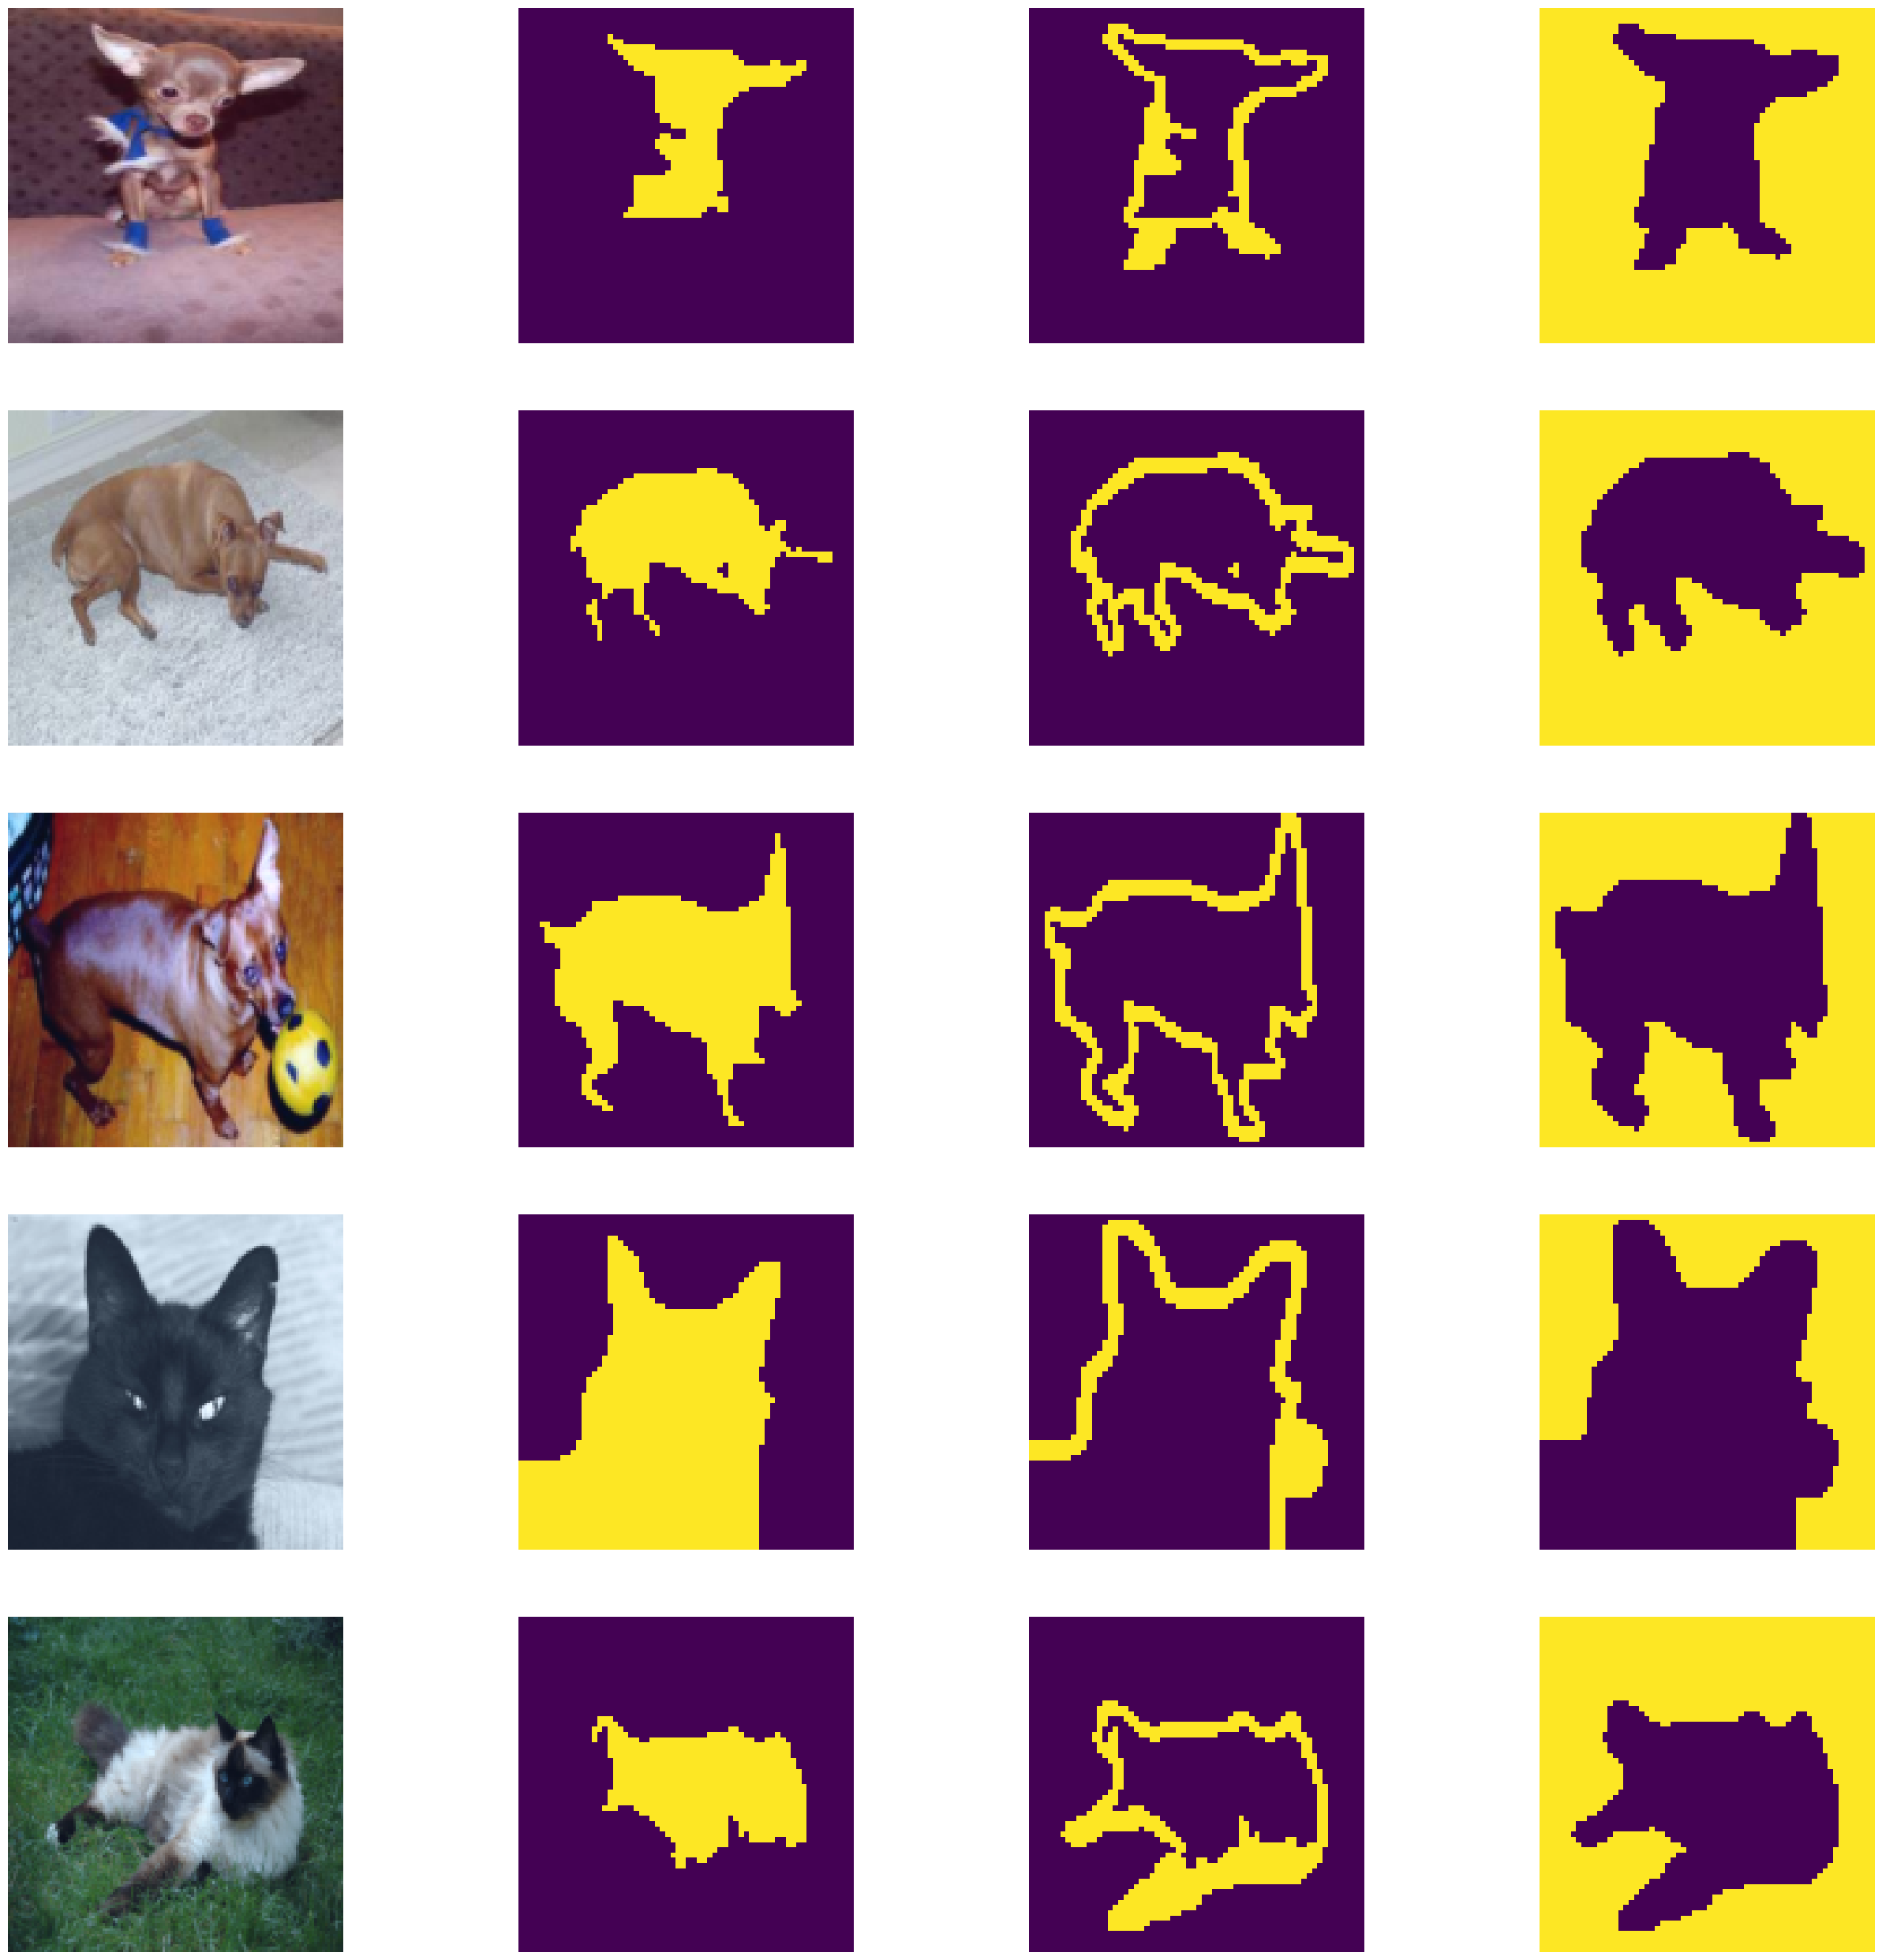

In [8]:
visualize_data(images[:5], masks[:5])

## Model Implementation - 7 points

### Backbone preparation - 2 points
Here, you will download the EfficientNet model and create classes that will allow you to extract features from the downloaded model. By features, we mean outputs of specified layers.

#### Feature Extraction - 1 point
First, let's download and inspect the model.

In [9]:
def get_efficient_net():
    return torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)

def get_example_input():
    return torch.rand(1, 3, IMAGE_HEIGHT, IMAGE_WIDTH) # [B, C, H, W]

efficient_net = get_efficient_net()
print(torchinfo.summary(efficient_net, input_size=(1, 3, IMAGE_HEIGHT, IMAGE_WIDTH)))
print(efficient_net)

/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn

Layer (type:depth-idx)                                       Output Shape              Param #
EfficientNet                                                 [1, 1000]                 --
├─Sequential: 1-1                                            [1, 32, 64, 64]           --
│    └─Conv2d: 2-1                                           [1, 32, 64, 64]           864
│    └─BatchNorm2d: 2-2                                      [1, 32, 64, 64]           64
│    └─SiLU: 2-3                                             [1, 32, 64, 64]           --
├─Sequential: 1-2                                            [1, 320, 4, 4]            --
│    └─Sequential: 2-4                                       [1, 16, 64, 64]           --
│    │    └─MBConvBlock: 3-1                                 [1, 16, 64, 64]           1,448
│    └─Sequential: 2-5                                       [1, 24, 32, 32]           --
│    │    └─MBConvBlock: 3-2                                 [1, 24, 32, 32]           6,00

In [10]:
getattr(efficient_net, "layers")[0]

Sequential(
  (block0): MBConvBlock(
    (depsep): Sequential(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (se): SequentialSqueezeAndExcitation(
      (squeeze): Linear(in_features=32, out_features=8, bias=True)
      (expand): Linear(in_features=8, out_features=32, bias=True)
      (activation): SiLU(inplace=True)
      (sigmoid): Sigmoid()
      (mul_a_quantizer): Identity()
      (mul_b_quantizer): Identity()
    )
    (proj): Sequential(
      (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(16, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    )
    (residual_quantizer): Identity()
  )
)

Fill in the code below according to the docstrings.  
There are several approaches to the task below one of them is to use `register_forward_hook`.  
The other one is to replace selected modules with appropriate wrappers.

In [11]:
DEVICE = "cpu"

In [12]:
class EffNetFeatureExtractor(torch.nn.Module):
    """
    Accepts an efficient_net and an list of layers for feature extraction (feature_layer_ids).
    When called returns a list containing the outputs of the selected layers.
    The parameter feature_layer_ids specifies the ids of the layers from
    efficient_net.layers.
    To be more precise for feature_layer_ids = [4, 6] it returns a list containing outputs of
    self.efficient_net.layers[4] and self.efficient_net.layers[6].
    """

    def __init__(
        self, efficient_net, feature_layer_ids: List[int]
    ) -> None:
        super().__init__()

        self.efficient_net = efficient_net
        self.feature_layer_ids = feature_layer_ids

        ## TODO {
        self.features = []  # list to store features from desired layers
        self._handles = []  # list to store hook hand

        for layer_id in feature_layer_ids:
            self._register_hook(efficient_net.layers[layer_id])
        ## }

    def _register_hook(self, module):
        def hook(module, input, output):
            # Ensure input and output are on the same device before appending
            if not input[0].device == output.device:
                output = output.to(input[0].device)  # Move output to input device
            self.features.append(output.detach())  # Detach output to avoid gradients

        handle = module.register_forward_hook(hook)
        self._handles.append(handle)


    def forward(self, x: torch.Tensor) -> List[torch.Tensor]:

        ## TODO {
      self.features = []  # Clear features for each forward pass
      x = self.efficient_net(x.to(DEVICE))  # Pass input through EfficientNet
      extracted_features = self.features
      ## }
      return extracted_features


def get_extracted_feature_shapes(net: EffNetFeatureExtractor):
    extracted_features = net(get_example_input())
    extracted_feature_shapes = [ef.shape for ef in extracted_features]
    return extracted_feature_shapes


##### TESTS START #####


def test_feature_extraction():
    efficient_net = get_efficient_net()
    net = EffNetFeatureExtractor(
        efficient_net=efficient_net, feature_layer_ids=[i for i in range(0, 7, 2)]
    )
    extracted_feature_shapes = get_extracted_feature_shapes(net)
    extracted_feature_shapes = get_extracted_feature_shapes(net) # this is on purpose

    expected_feature_shapes = [
        (1, 16, 64, 64),
        (1, 40, 16, 16),
        (1, 112, 8, 8),
        (1, 320, 4, 4),
    ]
    assert len(extracted_feature_shapes) == len(expected_feature_shapes)
    for extracted_fs, expected_fs in zip(
        extracted_feature_shapes, expected_feature_shapes
    ):
        assert extracted_fs == expected_fs


test_feature_extraction()

#####  TESTS END  #####

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


#### Feature Channel Matching - 1 point
In BiFPN we want all features to have the same number of channels (so we can add them easily).  
Complete the code below according to docstrings.  
`MatchChannels` is already implemented.

In [13]:
class MatchChannels(torch.nn.Module):
    """
    Given the input of shape (BATCH, in_channels, H, W),
    converts it to the one of shape (BATCH, out_channels, H, W)
    """

    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv = torch.nn.Conv2d(
            in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1
        )
        self.bn = torch.nn.BatchNorm2d(out_channels)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert len(x.shape) == 4
        x = self.conv(x)
        x = self.bn(x)
        return x


class BackboneWrapper(torch.nn.Module):
    """
    Given a efficient net backbone and channel_matching_fn (a function of form lambda x: MatchChannels(x, c))
    runs backbone to extract the features and uses modules created using channel_matching_fn to
    make channel dimension equal in all features.
    To be more specific
    if the output of the backbone consists of features of the following shapes
    (1, 16, 64, 64), (1, 18, 32, 32)
    then BackboneWrapper makes them
    (1, c, 64, 64), (1, c, 32, 32)

    It also freezes the parameters of the backbone so that they do not receive gradients.
    """

    def __init__(self, backbone: EffNetFeatureExtractor, channel_matching_fn):
        super().__init__()
        self.backbone = backbone

        ## TODO {
        # Freeze backbone params
        self.backbone.eval()
        with torch.no_grad():
            features = self.backbone(torch.randn(1, 3, 224, 224))  # Create dummy input for shape
            self.feature_channels = [f.shape[1] for f in features]

        # Create modules for channel matching based on initial channel dimensions
        self.match_layers = torch.nn.ModuleList([channel_matching_fn(in_channels) for in_channels in self.feature_channels])
        ## }

    def forward(self, x: torch.Tensor) -> List[torch.Tensor]:

        ## TODO {
        features = self.backbone(x)
        channel_matched_features = []
        for feature, match_layer in zip(features, self.match_layers):
            channel_matched_features.append(match_layer(feature))
        ## }

        return channel_matched_features


##### TESTS START #####


def test_backbone_basic():
    efficient_net = get_efficient_net()
    net = EffNetFeatureExtractor(
        efficient_net=efficient_net, feature_layer_ids=[i for i in range(0, 7, 2)]
    )

    wrapped = BackboneWrapper(
        backbone=net, channel_matching_fn=lambda x: MatchChannels(x, 24)
    )

    out = wrapped(get_example_input())

    out_shapes = [feature.shape for feature in out]

    expected_feature_shapes = [
        (1, 24, 64, 64),
        (1, 24, 16, 16),
        (1, 24, 8, 8),
        (1, 24, 4, 4),
    ]
    assert len(out_shapes) == len(expected_feature_shapes)
    for extracted_fs, expected_fs in zip(out_shapes, expected_feature_shapes):
        assert extracted_fs == expected_fs


def test_backbone_gradients():

    efficient_net = get_efficient_net()
    net = EffNetFeatureExtractor(
        efficient_net=efficient_net, feature_layer_ids=[i for i in range(0, 7, 2)]
    )

    wrapped = BackboneWrapper(
        backbone=net, channel_matching_fn=lambda x: MatchChannels(x, 24)
    )

    out = wrapped(get_example_input())

    sum = 0.0
    for feature in out:
        sum += feature.sum()

    sum.backward()

    backbone_parameter_names = set(
        [f"backbone.{name}" for name, _ in wrapped.backbone.named_parameters()]
    )
    contains_trainable_param = False
    for name, param in wrapped.named_parameters():
        if name in backbone_parameter_names:
            assert param.grad is None
        else:
            assert param.grad is not None
            contains_trainable_param = True
    assert contains_trainable_param


test_backbone_basic()
test_backbone_gradients()
#####  TESTS END  #####

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


### BiFPN - Feature Fusion - 3 points
Now we will implement the BiFPN network.  
First, we will start with single-way feature fusion to emphasize similarities and differences with FPN.  
Complete the code below according to docstrings.

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class BiFPNSingle(torch.nn.Module):
    """
    Given list of height features (list of length height),
    with each feature having feature_channels channels
    (that is i'th feature has shape (BATCH, feature_channels, H_i, W_i))
    performs the following sequence of operations
    res[0] = feature_list[0]
    res[i] = ACT(BN(CONVS(w[i][1] * feature_list[i] + w[i][2]*RESIZE(res[i-1]) + w[i][3]*aux_feature_list[i])))
    where the part w[i][3]*aux_feature_list[i] is present only when aux_feature_list is not None
    and weights w are calculated like in the BiFPN paper.
    Choice of CONVS is not specified."""

    def __init__(self, feature_channels: int, height: int) -> None:
        super().__init__()
        ## TODO {
        kernel_size = 3
        padding = 1
        self.layers = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Conv2d(feature_channels, feature_channels, kernel_size=kernel_size, padding=padding, bias=False),
                    nn.BatchNorm2d(feature_channels),
                    nn.SiLU(inplace=True),
                )
                for _ in range(height)
            ]
        )

        # Weight calculation function
        self.w_calculate = self._calculate_weights_alpha
        ## }

    def _calculate_weights_alpha(self, features):
        """
        Calculates weights w using the alpha method from the BiFPN paper.
        You can replace this function with a different weight calculation method.
        """
        omega = []
        for feature in features:
            omega.append(F.adaptive_avg_pool2d(feature, output_size=1))
        omega = torch.cat(omega, dim=1)
        weights = F.softmax(omega, dim=1)  # Apply softmax for normalization
        return weights.split(1, dim=1)

    def normalize_weights(self, weights: torch.Tensor):
        """
        Makes weights "add up to one", uses either softmax or the
        method from the BiFPN paper.
        """
        ## TODO {
        return F.softmax(weights, dim=1)
        ## }

    def forward(
        self,
        feature_list: List[torch.Tensor],
        aux_feature_list: Optional[List[torch.Tensor]] = None,
    ) -> List[torch.Tensor]:
        ## TODO {
        result = []
        weights = self.w_calculate(feature_list)  # Calculate weights w

        # First level
        result.append(feature_list[0])

        # Subsequent levels
        for i in range(1, len(feature_list)):
          resized_prev = F.interpolate(result[i - 1], size=feature_list[i].shape[2:], mode="nearest")
          # Handle potential single element weight list
          weights_i = weights[i] if len(weights[i]) > 1 else [weights[i][0], torch.zeros_like(feature_list[i]), torch.zeros_like(resized_prev)]
          weighted_features = weights_i[1] * feature_list[i] + weights_i[2] * resized_prev
          if aux_feature_list is not None:
              weighted_features += weights_i[3] * aux_feature_list[i]
          result.append(self.layers[i](weighted_features))
        ## }

        return result


##### TESTS START #####


def test_bifpn_single():

    bifpn_single = BiFPNSingle(32, 3)

    input_data = [
        torch.randn(1, 32, 64, 64),
        torch.randn(1, 32, 32, 32),
        torch.randn(1, 32, 7, 7),
    ]

    out = bifpn_single(input_data)

    assert len(out) == len(input_data)
    for o, i in zip(out, input_data):
        assert o.shape == i.shape


test_bifpn_single()
#####  TESTS END  #####

In [25]:
class BiFPN(torch.nn.Module):
    """
    Uses two BiFPNSingle modules to implement a BiFPN module as in the BiFPN paper.
    """

    def __init__(self, feature_channels: int, height: int) -> None:
        super().__init__()

        ## TODO {
        self.feature_channels = feature_channels
        self.height = height
        self.bifpn_down = BiFPNSingle(feature_channels, height)
        self.bifpn_up = BiFPNSingle(feature_channels, height)
        ## }

    def forward(self, feature_list: List[torch.Tensor]) -> List[torch.Tensor]:

        ## TODO {
        # features_dec_spd = []
        # # Top-down path
        # for x in feature_list[::-1]:
        #     features_dec_spd.append(x)

        # # Middle level for both paths
        # features_dec_spd.append(features_dec_spd[-1])

        # # Bottom-up path with connections
        # for i in range(self.height - 2, -1, -1):
        #     connection = features_dec_spd[i + 2]
        #     output = self.bifpn_up([features_dec_spd[i], connection])
        #     features_dec_spd[i + 1] = output[0]

        # return features_dec_spd[::-1]  # Reverse to get bottom-up order
        output_features = self.bifpn_up(feature_list)
        features_dec_spd = self.bifpn_down(output_features[::-1])  # Pass features from down direction


        ## }

        return features_dec_spd


##### TESTS START #####


def test_bifpn():

    bifpn_single = BiFPN(32, 3)

    input_data = [
        torch.randn(1, 32, 64, 64),
        torch.randn(1, 32, 32, 32),
        torch.randn(1, 32, 7, 7),
    ]

    out = bifpn_single(input_data)

    assert len(out) == len(input_data)
    for o, i in zip(out, input_data):
        assert o.shape == i.shape


test_bifpn_single()
#####  TESTS END  #####

### Segmentation Head - 1 point

In [16]:
class SegmentationHead(torch.nn.Module):
    """
    Given an input of shape (B, feature_channels, H, W)
    Produces the output of shape (B, num_classes, H', W') (where H', W' = output_shape)
    consisting of logits (that is no activation in the last layer) that can be used to classify each pixel.
    To do so uses additional convolution(s) that operate on input with inner_channels channels.
    """

    def __init__(
        self,
        feature_channels: int,
        output_shape: Tuple[int, int] = (PREDICTION_HEIGHT, PREDICTION_WIDTH),
        inner_channels: int = 64,
        num_classes: int = 3,
    ):
        super().__init__()
        self.output_shape = output_shape
        self.num_classes = num_classes
        ## TODO {
        # self.conv_sequence = torch.nn.Sequential(
        #     torch.nn.Conv2d(32, 32, kernel_size=3, padding=1),  # Maintain spatial dimensions
        #     torch.nn.ReLU(),
        #     torch.nn.Upsample(scale_factor=2, mode="bilinear"),
        #     torch.nn.Conv2d(32, 32, kernel_size=3, padding=1),  # Maintain spatial dimensions
        #     torch.nn.ReLU(),
        #     torch.nn.Upsample(scale_factor=2, mode="bilinear"),
        #     torch.nn.Conv2d(32, 32, kernel_size=3, padding=1),  # Maintain spatial dimensions
        #     torch.nn.ReLU(),
        #     torch.nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Increase feature channels
        #     torch.nn.Upsample(scale_factor=2, mode="bilinear"),
        #     torch.nn.ConvTranspose2d(64, 3, kernel_size=2, stride=2),  # Upsample to 64x64
        # )
        num_hidden = 3
        activation = nn.SiLU()
        conv_blocks = [torch.nn.Conv2d(feature_channels, inner_channels, kernel_size=3, padding=1), torch.nn.BatchNorm2d(inner_channels),
                      activation]
        for _ in range(num_hidden):
          conv_blocks.extend([torch.nn.Conv2d(inner_channels, inner_channels, kernel_size=3, padding=1), torch.nn.BatchNorm2d(inner_channels),
                      activation])
        self.conv_sequence = nn.Sequential(*conv_blocks)
        self.head = torch.nn.Conv2d(inner_channels, num_classes, kernel_size=3, stride=1, padding=1)

        ## }

    def forward(self, x):
        ## TODO {
        result = self.conv_sequence(x)
        result = self.head(result)
        result = F.interpolate(result, self.output_shape)
        # print(result.shape, self.num_classes, self.output_shape)
        ## }

        assert result.shape[0] == x.shape[0]
        assert result.shape[1] == self.num_classes
        assert result.shape[2:] == self.output_shape
        return result

### Network - 1 point

In [17]:
class Net(torch.nn.Module):
    """
    Uses BackboneWrapper,
    BiFPN(s) and
    SegmentationHead.
    Given an input of shape (BATCH, 3, H, W)
    returns a tensor of shape (BATCH, 3, H', W') (where H', W' = output_shape)
    with logits for pet, background, and outline.
    """

    def __init__(
        self,
        feature_channels: int = 32,
        output_shape: Tuple[int, int] = (PREDICTION_HEIGHT, PREDICTION_WIDTH),
        feature_layer_ids: List[int] = [0, 1, 2, 3, 4, 5, 6],
    ) -> None:
        super().__init__()

        ## TODO {

        self.output_shape = output_shape

        # Efficient net backbone wrapper

        efficient_net = get_efficient_net().to(DEVICE)
        net = EffNetFeatureExtractor(
            efficient_net=efficient_net, feature_layer_ids=feature_layer_ids
        )

        self.backbone_wrapper = BackboneWrapper(
            backbone=net, channel_matching_fn=lambda x: MatchChannels(x, feature_channels)
        )


        # BiFPN module (assuming s=len(feature_layer_ids))
        self.bifpn = BiFPN(feature_channels, len(feature_layer_ids))

        # Segmentation head
        self.segmentation_head = SegmentationHead(feature_channels)

        ## }

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        ## TODO {
        features = self.backbone_wrapper(x)

        # Process features through BiFPN
        processed_features = self.bifpn(features)

        # Predict logits with segmentation head
        result = self.segmentation_head(processed_features[-1])
        ## }
        return result

## Training and Evaluation - 2 points

### Metrics - 1 point

Implement accuracy and IOU metrics.

In [18]:
def accuracy(prediction: np.ndarray, ground_truth: np.ndarray) -> np.ndarray:
    """
    Given prediction of shape (B, C, H, W)
    and ground_truth of shape (B, C, H, W)
    outputs an array of shape (B, C).
    such that at the position (b, c) is the
    fraction of all pixels correctly classified
    """

    assert len(prediction.shape) == 4
    assert prediction.shape == ground_truth.shape
    assert np.logical_or(prediction == 1, prediction == 0).all()
    assert np.logical_or(ground_truth == 1, ground_truth == 0).all()

    ## TODO {
    num_pixels = prediction.shape[2] * prediction.shape[3]

    # Correctly classified
    correct_pixels = np.sum(prediction == ground_truth, axis=(2, 3))

    # Accuracy for each (b, c) pair
    result = correct_pixels / num_pixels
    ## }

    # print(result)
    assert result.shape == prediction.shape[:2]
    return result


##### TESTS START #####
def test_accuracy():
    a = np.zeros((1, 1, 64, 64))
    a[:, :, 32:48, 32:48] = 1
    b = np.zeros((1, 1, 64, 64))
    b[:, :, 47:63, 47:63] = 1
    assert np.isclose(
        accuracy(np.concatenate([a, a], axis=1), np.concatenate([a, b], axis=1)),
        np.array([1.0, (4096 - 510) / 4096])[None, :],
    ).all()


test_accuracy()
#####  TESTS END  #####

In [19]:
def iou_metric(prediction: np.ndarray, ground_truth: np.ndarray) -> np.ndarray:
    """
    Given prediction of shape (B, C, H, W)
    and ground_truth of shape (B, C, H, W)
    outputs an array of shape (B, C).
    such that at the position (b, c) is the
    value of the intersection of the prediction and the ground_truth mask
    (i.e. number of points where both are 1)
    divided by their union (i.e. number of points where at least one is 1)
    (assume 0/0 = 0).
    """

    assert len(prediction.shape) == 4
    assert prediction.shape == ground_truth.shape
    assert np.logical_or(prediction == 1, prediction == 0).all()
    assert np.logical_or(ground_truth == 1, ground_truth == 0).all()
    ## TODO {
    intersection = np.sum(np.logical_and(prediction, ground_truth), axis=(2, 3))
    union = np.sum(np.logical_or(prediction, ground_truth), axis=(2, 3))

    result = np.where(union != 0, intersection / union, 0)
    ## }
    assert result.shape == prediction.shape[:2]
    return result


##### TESTS START #####

def test_iou():

    a = np.zeros((1, 1, 64, 64))
    a[:, :, 32:48, 32:48] = 1
    b = np.zeros((1, 1, 64, 64))
    b[:, :, 47:63, 47:63] = 1

    assert np.isclose(
        iou_metric(np.concatenate([a, a], axis=1), np.concatenate([a, b], axis=1)),
        np.array([1.0, 1.0 / 511.0])[None, :],
    ).all()

    c = np.zeros((1, 1, 64, 64))

    assert np.isclose(
        iou_metric(c, c),
        np.array([0.0])[:, None],
    ).all()


test_iou()
#####  TESTS END  #####

<ipython-input-19-8c65eca12347>:21: RuntimeWarning: invalid value encountered in divide
  result = np.where(union != 0, intersection / union, 0)


### Eval Loop
Eval loop is already implemented.

In [20]:
DEVICE = torch.device("cuda")
def one_hot_encode_prediction(predictions: torch.Tensor) -> torch.Tensor:
    """
    Given predictions of shape (B, H, W)
    with number
    0 - representing pixels belonging to pet,
    1 - background,
    2 - outline
    one hot encodes it as
    single tensor of shape (B, 3, H, W), such that
    element (b, c, h, w) is 1 if pixel corresponds
    to class c and 0 otherwise.
    """

    assert len(predictions.shape) == 3

    predictions_oh = torch.nn.functional.one_hot(predictions, num_classes=3)
    predictions_oh = predictions_oh.permute(0, 3, 1, 2)  # B, C, H, W

    assert len(predictions_oh.shape) == 4
    assert predictions_oh.shape[1] == 3

    return predictions_oh

@torch.no_grad
def eval_fn(model, test_loader):
    model.eval()

    iou = []
    acc = []
    total = 0
    for data in test_loader:
        x, y = data
        ground_truth = one_hot_encode_prediction(y).cpu().numpy()
        x, y = x.to(DEVICE), y.to(DEVICE)

        logits = model(x)
        prediction = torch.argmax(logits.detach(), dim=-3, keepdim=False)
        prediction = one_hot_encode_prediction(prediction).cpu().numpy()

        iou.append(np.sum(iou_metric(prediction, ground_truth), axis=0))
        acc.append(np.sum(accuracy(prediction, ground_truth), axis=0))
        total += prediction.shape[0]

    iou = np.stack(iou, axis=-1).sum(-1) / total
    acc = np.stack(acc, axis=-1).sum(-1) / total
    assert len(iou.shape) == 1
    assert len(acc.shape) == 1
    assert iou.shape[0] == 3
    assert acc.shape[0] == 3

    print(f"IOU PET: {iou[0]}")
    print(f"IOU BG: {iou[1]}")
    print(f"IOU OUT: {iou[2]}")

    print(f"ACC PET: {acc[0]}")
    print(f"ACC BG: {acc[1]}")
    print(f"ACC OUT: {acc[2]}")

### Train Loop - 1 point

Complete the training loop.
You can use `CrossEntropyLoss` as a loss.

You should be able to achieve pet IOU >= 75%, background IOU >= 80%, and outline IOU >= 40% on the test set.  



In [21]:
def train(
    model,
    optimizer,
    train_loader,
    test_loader,
    num_epoch,
    eval_fn,
    weight=torch.tensor([1.0, 1.0, 1.0], device=DEVICE),
):
    """
    Args:
        model - model that given an image outputs a tensor
                with logits for determining whether a pixel belongs
                to the pet, the background, or the pet outline.
        eval_fn - function that given a model performs its evaluation on a given set;
                  called at the end of every epoch to report both test and train performance
        weight - used as weights for CrossEntropyLoss
    """
    ## TODO {
    criterion = torch.nn.CrossEntropyLoss(weight=weight)

    for epoch in range(num_epoch):
        model.train()
        train_loss = 0.0
        for input_img, img_label in train_loader:
            optimizer.zero_grad()
            model_pred = model(input_img)
            loss = criterion(model_pred, img_label.to(DEVICE))
            loss.backward()
            optimizer.step()

            train_loss += loss.item()


        train_loss /= len(train_loader)
        test_loss = eval_fn(model, test_loader)

        print(f'Batch: {epoch}, train loss: {train_loss}')

    ## }

In [26]:
def create_model_and_optimizer():
    model = Net()
    model.to(DEVICE)
    optimizer = torch.optim.Adam(params=model.parameters())
    return model, optimizer


model, optimizer = create_model_and_optimizer()
train(model, optimizer, TRAIN_LOADER, TEST_LOADER, 3, eval_fn)

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


IOU PET: 0.769325593209473
IOU BG: 0.8643968257626489
IOU OUT: 0.3812686166513234
ACC PET: 0.9302759926921504
ACC BG: 0.9239624056708231
ACC OUT: 0.9109997295754975
Batch: 0, train loss: 0.38030000821403837
IOU PET: 0.810435119148157
IOU BG: 0.8947728985192639
IOU OUT: 0.4647866993680979
ACC PET: 0.9438194426700055
ACC BG: 0.9433960393457005
ACC OUT: 0.9218492484541088
Batch: 1, train loss: 0.2684261988038602
IOU PET: 0.812759550357737
IOU BG: 0.8959747320841254
IOU OUT: 0.4957315108876314
ACC PET: 0.945723992402562
ACC BG: 0.9438321520892955
ACC OUT: 0.9242942479430704
Batch: 2, train loss: 0.23721868965936743


KeyboardInterrupt: 

## Inspection and Ablations - 3 points

First let's inspect the masks generated by the model.


In [ ]:
samples = next(iter(TEST_LOADER))
images, masks = samples

with torch.no_grad():
    pred = model(images.to(DEVICE))
    pred = torch.argmax(pred, dim=-3).cpu()


visualize_data(images[:5], pred[:5])

### Learned Weights - 1p
Inspect the weights learned by the first `BiFPNSingle` module of the first `BiFPN` in your model.  
That is the `BiFPNSingle` module that is used after preparing the features with `BackboneWrapper`.  
Make a plot visualizing them (the type of the plot is up to you).  
Briefly describe the results.  
Hint `.detach().cpu().numpy()` may be useful.

In [ ]:

## TODO {
## CODE

## }

## TODO {
## Description


## }

### Best and Worst Predictions - 1 point
Visualize the best and worst predictions made by the model on the test set (according to IOU PET).
Compare them with ground truths. Do you notice any problems? If you notice problems then how can they be addressed?

In [ ]:

## TODO {
# CODE

##}

## TODO {
# Answer

## }


### BiFPN Importance - 1 point
Check the importance of BiFPN feature fusion mechanism.  
Make BiFPN identity in your model and check the results.  

In [ ]:
## TODO {

## }
train(model, optimizer, TRAIN_LOADER, TEST_LOADER, 3, eval_fn)